In [1]:
!pip install emoji
!pip install pyspellchecker
!pip install wget
#!pip install pytorch-pretrained-bert
!pip install transformers
!pip install pandas
!pip install numpy
!pip install seaborn
!pip install keras
!pip install tqdm
!pip install sklearn
!pip install nltk

     |████████████████████████████████| 1.5 MB 1.4 MB/s eta 0:00:01
  Created wheel for nltk: filename=nltk-3.4.5-py3-none-any.whl size=1450714 sha256=d03bfaeeb30453433c024416b4f51c14bce5f590be8cbceb4a43673ce422d9ba
  Stored in directory: /root/.cache/pip/wheels/e3/c9/b0/ed26a73ef75a53145820825afa8e2d2c9b30fe9f6c10cd3202
Successfully built nltk


In [2]:
import os.path
from shutil import copyfile
import wget

In [3]:
ROOT_FOLDER = './'
TRAIN = ROOT_FOLDER + '/' + 'train.csv'
TEST = ROOT_FOLDER + '/' + 'test.csv'

In [4]:
if not os.path.exists(TRAIN):
  #drive.mount('/realornot')
  copyfile('./drive/My Drive/realornot/train.csv', TRAIN)
  copyfile('./drive/My Drive/realornot/test.csv', TEST)

In [5]:
!ls

launch.sh  paper.ipynb	tensorflow-tutorials  test.csv	train.csv


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
from tqdm import tqdm
import nltk
from nltk.tokenize import word_tokenize
import collections
from nltk.corpus import stopwords
from emoji import UNICODE_EMOJI
import re
import torch

from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from keras.preprocessing.sequence import pad_sequences

from transformers import BertTokenizer
from transformers import BertForSequenceClassification, AdamW, BertConfig



%matplotlib inline

Using TensorFlow backend.


In [7]:
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: GeForce GTX 1070 Ti


In [8]:
torch.cuda.empty_cache()

In [9]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [10]:
STOP_WORDS=set(stopwords.words('english'))

In [11]:
train_df = pd.read_csv(TRAIN)
train_df.head()

id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1

In [12]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [13]:
train_df.target.value_counts(normalize=True).mul(100).round(2).astype(str) + '%'

0    57.03%
1    42.97%
Name: target, dtype: object

In [14]:
train_df.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [15]:
len(train_df.keyword.unique())

222

In [16]:
len(train_df.keyword.unique())

222

In [17]:
len(train_df.location.unique())

3342

In [18]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [19]:
def create_corpus_word(df, test, column='text'):
    corpus=[]
    for row in tqdm(df[column]):
       for word in word_tokenize(row):
          if (test(word)):
                corpus.append(word)
    return corpus

In [20]:
def create_corpus_symbol(df, test, column='text'):
  corpus = []
  for row in tqdm(df[column]):
    for word in word_tokenize(row):
          for symbol in word:
            if (test(word)):
                corpus.append(symbol)
  return corpus

In [21]:
def create_corpus_sentence(df, test, column='text'):
  corpus = []
  for row in tqdm(df[column]):
    if (test(row)):
      corpus.append(row)
  return corpus

In [22]:
def draw_corpus_stat(corpus):
  counter=collections.Counter(corpus)
  most=counter.most_common()
  x=[]
  y=[]
  for word,count in most[:20]:
    x.append(word)
    y.append(count)
  sns.barplot(x=y, y=x)

In [23]:
def draw_confusion_matrix(matrix):
  class_names=[0,1] # name  of classes
  fig, ax = plt.subplots()
  tick_marks = np.arange(len(class_names))
  plt.xticks(tick_marks, class_names)
  plt.yticks(tick_marks, class_names)
  # create heatmap
  sns.heatmap(pd.DataFrame(matrix), annot=True, cmap="YlGnBu" ,fmt='g')
  ax.xaxis.set_label_position("top")
  plt.tight_layout()
  plt.title('Confusion matrix', y=1.1)
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

In [24]:
def print_results_info(y_test, y_pred):
  print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
  print("Precision:",metrics.precision_score(y_test, y_pred))
  print("Recall:",metrics.recall_score(y_test, y_pred))

100%|██████████| 7613/7613 [00:01<00:00, 4347.74it/s]


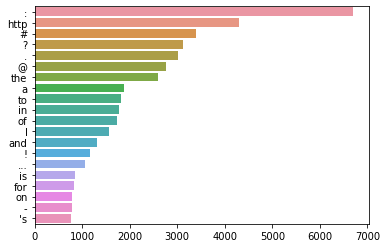

In [25]:
word_corpus = create_corpus_word(train_df, lambda x : True)
draw_corpus_stat(word_corpus)

100%|██████████| 7613/7613 [00:01<00:00, 4092.45it/s]


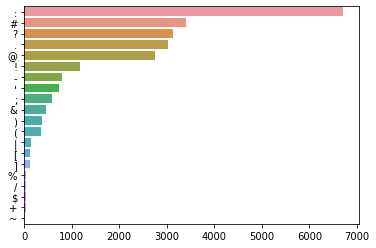

In [26]:
punct_corpus=create_corpus_symbol(train_df, lambda x : x in string.punctuation)
draw_corpus_stat(punct_corpus)

100%|██████████| 7613/7613 [00:01<00:00, 4316.64it/s]


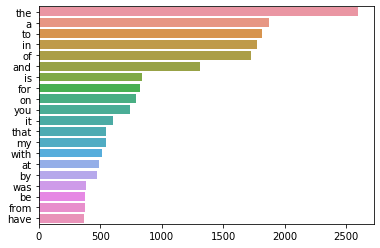

In [27]:
stop_words_corpus=create_corpus_word(train_df, lambda x : x in STOP_WORDS)
draw_corpus_stat(stop_words_corpus)

In [28]:
EMOJIES = set(UNICODE_EMOJI.keys())
emoji_corpus=create_corpus_symbol(train_df, lambda x : x in EMOJIES)
len(emoji_corpus)

100%|██████████| 7613/7613 [00:01<00:00, 4051.69it/s]


0

Text(0.5, 0.98, 'Average word length in each tweet')

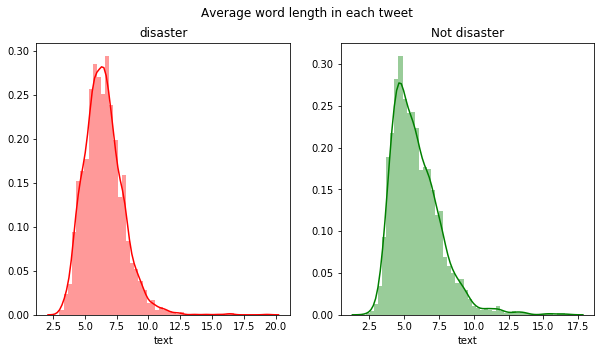

In [29]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
word=train_df[train_df['target']==1]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
ax1.set_title('disaster')

word=train_df[train_df['target']==0]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='green')
ax2.set_title('Not disaster')
fig.suptitle('Average word length in each tweet')

Text(0.5, 0.98, 'Word count in each tweet')

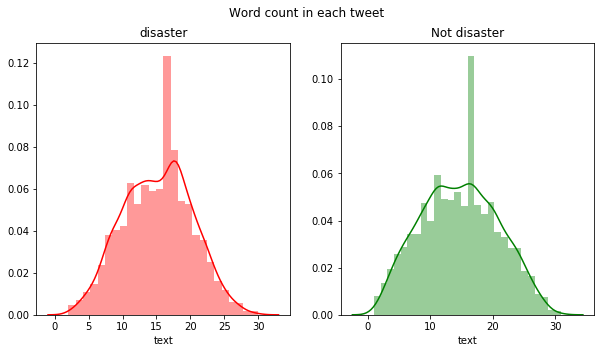

In [30]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
word=train_df[train_df['target']==1]['text'].str.split().apply(lambda x : len(x))
sns.distplot(word,ax=ax1,color='red')
ax1.set_title('disaster')

word=train_df[train_df['target']==0]['text'].str.split().apply(lambda x : len(x))
sns.distplot(word,ax=ax2,color='green')
ax2.set_title('Not disaster')
fig.suptitle('Word count in each tweet')

Text(0.5, 0.98, 'Symbols count in each tweet')

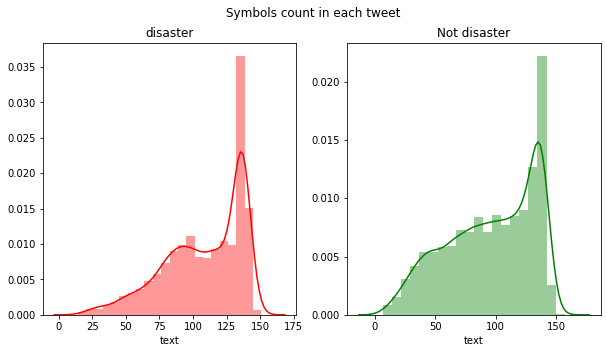

In [31]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
word=train_df[train_df['target']==1]['text'].str.len()
sns.distplot(word,ax=ax1,color='red')
ax1.set_title('disaster')

word=train_df[train_df['target']==0]['text'].str.len()
sns.distplot(word,ax=ax2,color='green')
ax2.set_title('Not disaster')
fig.suptitle('Symbols count in each tweet')

In [32]:
def remove_url(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

def remove_punct(text):
    #string.punctuation
    punct = '"#$%&\'()*+-/:;<=>@[\\]^_`{|}~'
    table=str.maketrans('','',punct)
    return text.translate(table)  

def remove_stop_words(text):
  return ' '.join([word for word in text.split() if word not in (STOP_WORDS)])

def remove_emoji(text):
    # emoji_pattern = re.compile("["
    #                        u"\U0001F600-\U0001F64F"  # emoticons
    #                        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
    #                        u"\U0001F680-\U0001F6FF"  # transport & map symbols
    #                        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
    #                        u"\U00002702-\U000027B0"
    #                        u"\U000024C2-\U0001F251"
    #                        "]+", flags=re.UNICODE)
    # return emoji_pattern.sub(r'', text)
    return text


In [33]:
def clean_text_column(df, column='text'):
  df[column] = df[column].apply(lambda x: x.lower())
  df[column] = df[column].apply(lambda x: remove_html(x))
  df[column] = df[column].apply(lambda x: remove_url(x))
  df[column] = df[column].apply(lambda x: remove_punct(x))
  df[column] = df[column].apply(lambda x: remove_stop_words(x))
  df[column] = df[column].apply(lambda x: remove_emoji(x))
  return df

def clean_data(df):
  df = clean_text_column(df, 'text')
  df['location'] = df.location.astype('str').fillna("nan")
  df = clean_text_column(df, 'location')
  
  df['keyword'] = df.keyword.fillna("nan").astype('category').cat.codes
  df['word_count'] = df['text'].apply(lambda x: len(x.split()))
  return df

In [34]:
train_df = clean_data(train_df)
train_df.head()

id  keyword location                                               text  \
0   1      146      nan       deeds reason earthquake may allah forgive us   
1   4      146      nan             forest fire near la ronge sask. canada   
2   5      146      nan  residents asked shelter place notified officer...   
3   6      146      nan  13,000 people receive wildfires evacuation ord...   
4   7      146      nan  got sent photo ruby alaska smoke wildfires pou...   

   target  word_count  
0       1           7  
1       1           7  
2       1          11  
3       1           7  
4       1           9

100%|██████████| 7613/7613 [00:00<00:00, 1155129.20it/s]


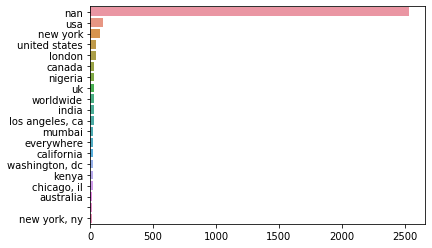

In [35]:
location_corpus=create_corpus_sentence(train_df, lambda x : True, "location")
draw_corpus_stat(location_corpus)

In [36]:
sent_corpus=create_corpus_sentence(train_df, lambda x : True)
print('Max sentence length: ', max([len(sen) for sen in sent_corpus]))

100%|██████████| 7613/7613 [00:00<00:00, 1035887.64it/s]

Max sentence length:  138


In [37]:
MAX_SENT_LENGTH = 140

In [38]:
BERT_MODEL='bert-large-uncased'

In [39]:
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL, do_lower_case=True)

In [40]:
def encode_sentencies(sentencies): 
  encoded_sentencies = []
  for sent in tqdm(sentencies):
    encoded_sent = tokenizer.encode(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'

                        # This function also supports truncation and conversion
                        # to pytorch tensors, but we need to do padding, so we
                        # can't use these features :( .
                        #max_length = 128,          # Truncate all sentences.
                        #return_tensors = 'pt',     # Return pytorch tensors.
                   )
    encoded_sentencies.append(encoded_sent)
  
  return encoded_sentencies
    
input_ids = encode_sentencies(train_df['text'])

# Print sentence 0, now as a list of IDs.
print("")
print('Original: ', train_df['text'][0])
print('Token IDs:', input_ids[0])

100%|██████████| 7613/7613 [00:02<00:00, 2641.52it/s]


Original:  deeds reason earthquake may allah forgive us
Token IDs: [101, 15616, 3114, 8372, 2089, 16455, 9641, 2149, 102]


In [41]:
def apply_padding(enc_sentencies, max_len):
  print('\nPadding/truncating all sentences to %d values...' % max_len)
  print('\nPadding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))
  
  padded = pad_sequences(enc_sentencies, maxlen=max_len, dtype="long", 
                          value=0, truncating="post", padding="post")
  
  return padded

padded = apply_padding(input_ids, MAX_SENT_LENGTH)

print("")
print('Original: ', train_df['text'][0])
print('Token IDs:', input_ids[0])
print('Padded IDs:', padded[0])


Padding/truncating all sentences to 140 values...

Padding token: "[PAD]", ID: 0

Original:  deeds reason earthquake may allah forgive us
Token IDs: [101, 15616, 3114, 8372, 2089, 16455, 9641, 2149, 102]
Padded IDs: [  101 15616  3114  8372  2089 16455  9641  2149   102     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     

In [42]:
def extract_attention_masks(padded_sentencies):
  attention_masks = []
  # For each sentence...
  for sent in tqdm(padded_sentencies):
      
      # Create the attention mask.
      #   - If a token ID is 0, then it's padding, set the mask to 0.
      #   - If a token ID is > 0, then it's a real token, set the mask to 1.
      att_mask = [int(token_id > 0) for token_id in sent]
      
      # Store the attention mask for this sentence.
      attention_masks.append(att_mask)
  return attention_masks

attention_masks = extract_attention_masks(padded)

print("")
print('Original: ', train_df['text'][0])
print('Token IDs:', input_ids[0])
print('Padded IDs:', padded[0])
print('Attention mask:', attention_masks[0])

100%|██████████| 7613/7613 [00:00<00:00, 9863.39it/s] 


Original:  deeds reason earthquake may allah forgive us
Token IDs: [101, 15616, 3114, 8372, 2089, 16455, 9641, 2149, 102]
Padded IDs: [  101 15616  3114  8372  2089 16455  9641  2149   102     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0]
Attention ma

In [43]:
labels = train_df["target"].to_numpy()
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(padded, labels, 
                                                            random_state=2020, test_size=0.1)
# Do the same for the masks.
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels,
                                             random_state=2020, test_size=0.1)



train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [44]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here.
# For fine-tuning BERT on a specific task, the authors recommend a batch size of
# 16 or 32.

batch_size = 4

# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


In [45]:
model = BertForSequenceClassification.from_pretrained(
    BERT_MODEL, # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
  
)

# Tell pytorch to run this model on the GPU.
model.cuda();

In [46]:
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 393 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 1024)
bert.embeddings.position_embeddings.weight               (512, 1024)
bert.embeddings.token_type_embeddings.weight               (2, 1024)
bert.embeddings.LayerNorm.weight                             (1024,)
bert.embeddings.LayerNorm.bias                               (1024,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight        (1024, 1024)
bert.encoder.layer.0.attention.self.query.bias               (1024,)
bert.encoder.layer.0.attention.self.key.weight          (1024, 1024)
bert.encoder.layer.0.attention.self.key.bias                 (1024,)
bert.encoder.layer.0.attention.self.value.weight        (1024, 1024)
bert.encoder.layer.0.attention.self.value.bias               (1024,)
bert.encoder.layer.0.attention.output.dense.weight      (1024, 1024)
bert.encoder.layer.0.attention.output.dense.bias             (

In [47]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [48]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs (authors recommend between 2 and 4)
epochs = 4

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [49]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [50]:

def flat_f1(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return metrics.f1_score(labels_flat, pred_flat)

In [51]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


In [52]:
import random

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128


# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output) because we
        # have provided the `labels`.
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        # The call to `model` always returns a tuple, so we need to pull the 
        # loss value out of the tuple.
        loss = outputs[0]

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have
            # not provided labels.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_f1(logits, label_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
        nb_eval_steps += 1

    # Report the final accuracy for this validation run.
    print("  F1: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 4 ========
Training...
  Batch    40  of  1,713.    Elapsed: 0:00:19.
  Batch    80  of  1,713.    Elapsed: 0:00:38.
  Batch   120  of  1,713.    Elapsed: 0:00:56.
  Batch   160  of  1,713.    Elapsed: 0:01:15.
  Batch   200  of  1,713.    Elapsed: 0:01:32.
  Batch   240  of  1,713.    Elapsed: 0:01:49.
  Batch   280  of  1,713.    Elapsed: 0:02:06.
  Batch   320  of  1,713.    Elapsed: 0:02:23.
  Batch   360  of  1,713.    Elapsed: 0:02:39.
  Batch   400  of  1,713.    Elapsed: 0:02:56.
  Batch   440  of  1,713.    Elapsed: 0:03:13.
  Batch   480  of  1,713.    Elapsed: 0:03:31.
  Batch   520  of  1,713.    Elapsed: 0:03:47.
  Batch   560  of  1,713.    Elapsed: 0:04:04.
  Batch   600  of  1,713.    Elapsed: 0:04:21.
  Batch   640  of  1,713.    Elapsed: 0:04:38.
  Batch   680  of  1,713.    Elapsed: 0:04:55.
  Batch   720  of  1,713.    Elapsed: 0:05:12.
  Batch   760  of  1,713.    Elapsed: 0:05:29.
  Batch   800  of  1,713.    Elapsed: 0:05:46.
  Batch   840  of

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


  F1: 0.66
  Validation took: 0:00:16

======== Epoch 2 / 4 ========
Training...
  Batch    40  of  1,713.    Elapsed: 0:00:17.
  Batch    80  of  1,713.    Elapsed: 0:00:34.
  Batch   120  of  1,713.    Elapsed: 0:00:51.
  Batch   160  of  1,713.    Elapsed: 0:01:08.
  Batch   200  of  1,713.    Elapsed: 0:01:24.
  Batch   240  of  1,713.    Elapsed: 0:01:41.
  Batch   280  of  1,713.    Elapsed: 0:01:58.
  Batch   320  of  1,713.    Elapsed: 0:02:15.
  Batch   360  of  1,713.    Elapsed: 0:02:31.
  Batch   400  of  1,713.    Elapsed: 0:02:48.
  Batch   440  of  1,713.    Elapsed: 0:03:05.
  Batch   480  of  1,713.    Elapsed: 0:03:22.
  Batch   520  of  1,713.    Elapsed: 0:03:39.
  Batch   560  of  1,713.    Elapsed: 0:03:56.
  Batch   600  of  1,713.    Elapsed: 0:04:12.
  Batch   640  of  1,713.    Elapsed: 0:04:29.
  Batch   680  of  1,713.    Elapsed: 0:04:46.
  Batch   720  of  1,713.    Elapsed: 0:05:02.
  Batch   760  of  1,713.    Elapsed: 0:05:19.
  Batch   800  of  1,713. 

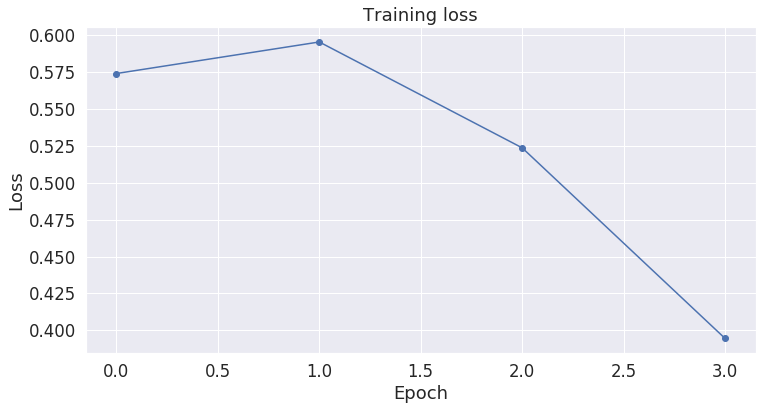

In [53]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o')

# Label the plot.
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

In [54]:
test_df = pd.read_csv(TEST)
test_df.head()

id keyword location                                               text
0   0     NaN      NaN                 Just happened a terrible car crash
1   2     NaN      NaN  Heard about #earthquake is different cities, s...
2   3     NaN      NaN  there is a forest fire at spot pond, geese are...
3   9     NaN      NaN           Apocalypse lighting. #Spokane #wildfires
4  11     NaN      NaN      Typhoon Soudelor kills 28 in China and Taiwan

In [55]:
len(test_df)

3263

In [56]:
test_df = clean_data(test_df)
test_df.head()

id  keyword location                                               text  \
0   0      146      nan                        happened terrible car crash   
1   2      146      nan  heard earthquake different cities, stay safe e...   
2   3      146      nan  forest fire spot pond, geese fleeing across st...   
3   9      146      nan             apocalypse lighting. spokane wildfires   
4  11      146      nan             typhoon soudelor kills 28 china taiwan   

   word_count  
0           4  
1           7  
2          10  
3           4  
4           6

In [57]:
sent_corpus=create_corpus_sentence(test_df, lambda x : True)
print('Max sentence length: ', max([len(sen) for sen in sent_corpus]))

100%|██████████| 3263/3263 [00:00<00:00, 916740.17it/s]

Max sentence length:  131


In [58]:
t_input_ids = encode_sentencies(test_df['text'])
t_padded = apply_padding(t_input_ids, MAX_SENT_LENGTH)
t_attention_masks = extract_attention_masks(t_padded)

print("")
print('Original: ', test_df['text'][0])
print('Token IDs:', t_input_ids[0])
print('Padded IDs:', t_padded[0])
print('Attention mask:', t_attention_masks[0])

 31%|███       | 1009/3263 [00:00<00:00, 10081.72it/s]


Padding/truncating all sentences to 140 values...

Padding token: "[PAD]", ID: 0


100%|██████████| 3263/3263 [00:00<00:00, 9993.13it/s] 


Original:  happened terrible car crash
Token IDs: [101, 3047, 6659, 2482, 5823, 102]
Padded IDs: [ 101 3047 6659 2482 5823  102    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0]
Attention mask: [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [59]:
len(t_input_ids[1])

11

In [60]:
prediction_inputs = torch.tensor(t_padded)
prediction_masks = torch.tensor(t_attention_masks)
#prediction_labels = torch.tensor(labels)

In [61]:
prediction_data = TensorDataset(prediction_inputs, prediction_masks)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [62]:

print('Predicting labels for {:,} test sentences...'.format(len(prediction_inputs)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions = []

# Predict 
for batch in tqdm(prediction_dataloader):
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  
  
  # Store predictions and true labels
  predictions.extend(np.argmax(logits, axis=1).flatten())
  

print('    DONE.')

  0%|          | 0/816 [00:00<?, ?it/s]

Predicting labels for 3,263 test sentences...


100%|██████████| 816/816 [01:10<00:00, 11.52it/s]

    DONE.


In [63]:
len(predictions)

3263

In [64]:
predictions[:10]

[1, 1, 1, 1, 1, 1, 0, 0, 0, 0]

In [65]:
result = pd.DataFrame(predictions, columns=['target'])
result.insert(loc=0, column='id', value= test_df['id'])

result.head()

id  target
0   0       1
1   2       1
2   3       1
3   9       1
4  11       1

In [66]:
result.to_csv("./file.csv", index=False)

In [67]:
len(test_df)

3263